# **Assigment 2: Regression Analysis and Model Selection**

**Done by:**\
*Noor Shamali 1200016*\
Yafa  : 1200708

## **Data Preprocessing Steps:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/cars.csv'

# Load the CSV file into a DataFrame
cars_df = pd.read_csv(file_path)
cars_df.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa


***The dataset contains the following columns:***

**Car Name**

**Price**

**Engine Capacity**

**Cylinder**

**Horse Power**

**Top Speed**

**Seats**

**Brand**

**Country**




### **Columns Information**

In [3]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


###  **Extract unique currency identifiers from the 'price' column to standarize it later**

In [4]:
#^: Ensures we match only at the beginning of the string.
#Matches 2-3 uppercase letters (common pattern for currency codes).

cars_df['price'].str.extract(r'(\b[A-Z]{3}\b)').dropna().drop_duplicates()


,0
0,TBD
1,SAR
997,EGP
1389,BHD
2293,QAR
3222,OMR
4128,KWD
5064,AED


###  **Preprocessing the price**

In [5]:
# First: Preprocessing the price
# Standardize all prices to a common currency, such as USD, for a uniform target variable.
import numpy as np
exchange_currencies = {
    "SAR": 0.27,  # Saudi Riyal to USD
    "AED": 0.27,  # UAE Dirham to USD
    "KWD": 3.25,  # Kuwaiti Dinar to USD
    "QAR": 0.27,  # Qatari Riyal to USD
    "OMR": 2.60,  # Omani Rial to USD
    "BHD": 2.65,  # Bahraini Dinar to USD
    "EGP": 0.032  # Egyptian Pound to USD
}

# Function to convert price with currency to USD
def convert_to_usd(price):
    # Convert price to string if it isn't already
    price = str(price)

    for currency, rate in exchange_currencies.items():
        if currency in price:
            # Remove the currency symbol
            # Remove any commas within the number
            # .strip(): Removes any extra whitespace around the cleaned number.
            # Convert the cleaned price string to a numeric value.
            # errors='coerce': If the conversion fails pd.to_numeric will assign NaN to price_numeric.
            price_numeric = pd.to_numeric(price.replace(currency, '').replace(',', '').strip(), errors='coerce')

            if pd.notnull(price_numeric):
                # Would be NaN if the conversion from string to numeric failed
                # Performs the conversion
                return price_numeric * rate

    return np.nan  # If we don't recognize the currency, return NaN

# Apply the function to the 'price' column
cars_df['price_usd'] = cars_df['price'].apply(convert_to_usd)

 # Drop rows with NaN prices after conversion
cars_df.dropna(subset=['price_usd'], inplace=True)

# Display the results
cars_df[['price', 'price_usd']]

,price,price_usd
1,"SAR 140,575",37955.25
2,"SAR 98,785",26671.95
3,"SAR 198,000",53460.00
5,"SAR 95,335",25740.45
6,"SAR 82,845",22368.15
...,...,...
6300,"AED 1,400,000",378000.00
6302,"AED 1,990,000",537300.00
6304,"AED 1,766,100",476847.00
6305,"AED 1,400,000",378000.00


###  **Check for Missing Values**

In [6]:
missing_values = cars_df.isnull().sum()
print("\nMissing Values Check:")
print(missing_values[missing_values > 0])  # Only print columns with missing values



Missing Values Check:
cylinder    531
dtype: int64


### **Handle Missing Values**

In [7]:
# Handle missing values for numerical columns with median values
numeric_columns = ['engine_capacity', 'cylinder', 'horse_power', 'top_speed']
for column in numeric_columns:
    # Ensure non-numeric values are converted to NaN
    if not pd.api.types.is_numeric_dtype(cars_df[column]):  # Check if the column is numeric
        cars_df[column] = pd.to_numeric(cars_df[column], errors='coerce')  # Convert to numeric with NaN for errors

    # Fill missing values with the median if any remain
    if cars_df[column].isnull().sum() > 0:
        print(f"Missing values in {column}, filling with median")
        cars_df[column] = cars_df[column].fillna(cars_df[column].median())

# Handle missing values for categorical columns with mode (most frequent value)
categorical_columns = ['seats', 'brand', 'country']
for column in categorical_columns:
    if cars_df[column].isnull().sum() > 0:
        print(f"Missing values in {column}, filling with mode")
        if not cars_df[column].mode().empty:  # Ensure mode exists
            cars_df[column] = cars_df[column].fillna(cars_df[column].mode()[0])

# Verify that there are no more missing values
print("\nDataset after handling missing values:")
print(cars_df.isnull().sum())  # Confirm no missing values remain

cars_df

Missing values in engine_capacity, filling with median
Missing values in cylinder, filling with median
Missing values in horse_power, filling with median
Missing values in top_speed, filling with median

Dataset after handling missing values:
car name           0
price              0
engine_capacity    0
cylinder           0
horse_power        0
top_speed          0
seats              0
brand              0
country            0
price_usd          0
dtype: int64


,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,price_usd
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4.0,180.0,216.0,8.8,peugeot,ksa,37955.25
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4.0,102.0,145.0,4 Seater,suzuki,ksa,26671.95
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4.0,420.0,216.0,7.5,ford,ksa,53460.00
5,Honda HR-V 2021 1.8 i-VTEC EX,"SAR 95,335",1.8,4.0,140.0,190.0,5 Seater,honda,ksa,25740.45
6,Peugeot Expert 2021 Van L3 A/T,"SAR 82,845",2.0,4.0,120.0,170.0,N A,peugeot,ksa,22368.15
...,...,...,...,...,...,...,...,...,...,...
6300,Lamborghini Huracan 2021 EVO Spyder,"AED 1,400,000",5.2,10.0,640.0,325.0,2 Seater,lamborghini,uae,378000.00
6302,Lamborghini Aventador SVJ 2021 LP770-4 Coupe,"AED 1,990,000",6.5,12.0,770.0,350.0,2 Seater,lamborghini,uae,537300.00
6304,Ferrari SF90 Stradale 2021 4.0T V8 Plug-in-Hybrid,"AED 1,766,100",4.0,8.0,25.0,800.0,Automatic,ferrari,uae,476847.00
6305,Rolls Royce Wraith 2021 6.6L Base,"AED 1,400,000",6.6,12.0,624.0,250.0,4 Seater,rolls-royce,uae,378000.00


 ###  **Encoding categorical features**

In [8]:

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Identify categorical columns
categorical_columns = cars_df.select_dtypes(include=['object']).columns

# Apply LabelEncoder to each categorical column and replace in the DataFrame
for column in categorical_columns:
    cars_df[column] = label_encoder.fit_transform(cars_df[column])

cars_df

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,price_usd
1,1675,2794,2.0,4.0,180.0,216.0,64,61,2,37955.25
2,1885,3302,1.5,4.0,102.0,145.0,40,72,2,26671.95
3,473,2885,2.3,4.0,420.0,216.0,60,25,2,53460.00
5,642,3284,1.8,4.0,140.0,190.0,45,32,2,25740.45
6,1668,3234,2.0,4.0,120.0,170.0,69,61,2,22368.15
...,...,...,...,...,...,...,...,...,...,...
6300,1029,13,5.2,10.0,640.0,325.0,22,44,6,378000.00
6302,1025,20,6.5,12.0,770.0,350.0,22,44,6,537300.00
6304,453,18,4.0,8.0,25.0,800.0,68,23,6,476847.00
6305,1782,13,6.6,12.0,624.0,250.0,40,66,6,378000.00


###  **Feature Scaling (Standardization)**

In [9]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Select only numerical columns from the DataFrame
numerical_columns = cars_df.select_dtypes(include=['float64', 'int64']).columns

# Standardize all numerical features
cars_df[numerical_columns] = scaler.fit_transform(cars_df[numerical_columns])

cars_df

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,price_usd
1,1.004441,1.325729,-0.233784,-0.632567,-0.574137,-0.124861,1.956958,0.871919,-0.643415,-0.317966
2,1.344044,1.891494,-0.234871,-0.632567,-0.998741,-1.645805,-0.373489,1.365513,-0.643415,-0.423376
3,-0.939384,1.427077,-0.233132,-0.632567,0.732336,-0.124861,1.568551,-0.743476,-0.643415,-0.173118
5,-0.666084,1.871447,-0.234219,-0.632567,-0.791883,-0.681826,0.112021,-0.429372,-0.643415,-0.432078
6,0.993121,1.815762,-0.233784,-0.632567,-0.900755,-1.110261,2.442468,0.871919,-0.643415,-0.463583
...,...,...,...,...,...,...,...,...,...,...
6300,-0.040244,-1.771498,-0.226829,2.623343,1.929936,2.210111,-2.121324,0.109094,1.330742,2.858782
6302,-0.046712,-1.763702,-0.224004,3.708646,2.637609,2.745655,-2.121324,0.109094,1.330742,4.346985
6304,-0.971727,-1.765929,-0.229437,1.538040,-1.417901,12.385446,2.345366,-0.833221,1.330742,3.782225
6305,1.177477,-1.771498,-0.223787,3.708646,1.842838,0.603479,-0.373489,1.096280,1.330742,2.858782


In [ ]:
cars_df['seats']

,seats
1,1.956958
2,-0.373489
3,1.568551
5,0.112021
6,2.442468
...,...
6300,-2.121324
6302,-2.121324
6304,2.345366
6305,-0.373489


### **60-20-20 Split , 60% for training, 20% for validation, and 20% for testing**

In [10]:
# Import required library
from sklearn.model_selection import train_test_split

# Separate features and target
features = cars_df.drop(columns=['price_usd']) # Exclude the target variable and irrelevant columns
target = cars_df['price_usd']  # The target variable

# Split the data: 60% training, 20% validation, 20% test
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=42)  # 60% train, 40% temp
features_val, features_test, target_val, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42)  # Split 40% temp into 20% val and 20% test

# Display shapes of the split datasets
print("\nDataset Splits:")
print(f"Training Set: {features_train.shape}, Validation Set: {features_val.shape}, Test Set: {features_test.shape}")

# Verify proportions
total_rows = len(cars_df)
print("\nProportions:")
print(f"Training Set: {len(features_train) / total_rows:.2%}")
print(f"Validation Set: {len(features_val) / total_rows:.2%}")
print(f"Test Set: {len(features_test) / total_rows:.2%}")



Dataset Splits:
Training Set: (2987, 9), Validation Set: (996, 9), Test Set: (996, 9)

Proportions:
Training Set: 59.99%
Validation Set: 20.00%
Test Set: 20.00%


## **Building Regression Models**

#### **Applying Regularization Techniques Use LASSO and Ridge regularization to control overfitting.**

##### **Finding alpha value**

In [11]:
from sklearn.model_selection import  GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Define the parameter grid for Lasso and Ridge models
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Lasso model with GridSearchCV
lasso = Lasso()
lasso_grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(features_train, target_train)

# Results for Lasso
alpha_lasso = lasso_grid_search.best_params_['alpha']
print("Best alpha for Lasso:", lasso_grid_search.best_params_)
print("Best MSE for Lasso:", -lasso_grid_search.best_score_)

Best alpha for Lasso: {'alpha': 0.01}
Best MSE for Lasso: 0.2515703609135028


##### **Hyperparameter Tuning and Evaluation of Ridge Regression with GridSearchCV**

##### **Model Evaluation After Hyperparameter Tuning: Comparing Lasso and Ridge Regression**

### **Regression Linear Model**

####1- **Linear Regression without Regularization**

##### **1.1 Gradient Descent**
$$
\theta = \theta - \alpha \frac{1}{m} X^T (X\theta - y)
$$

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Gradient Descent Implementation
#optimize weights θ using Gradient Descent for Linear Regression.
#alpha: Learning rate, controls the step size for each gradient descent update
def gradient_descent(feature_matrix, target_value, alpha=0.01, iterations=1000):

    #m: Number of samples (rows) in the feature matrix
    #n: Number of features (columns)
    m, n = feature_matrix.shape
    #Adds a bias term to the feature matrix
    feature_matrix = np.hstack([np.ones((m, 1)), feature_matrix])  # Add bias term
    #Initializes the weight vector.
    #Its size is n+1
    #n: The number of features.
    #+1: Accounts for the bias term.
    theta = np.zeros((n + 1,))  # Initialize weights

    for _ in range(iterations):
      # @ is for matrix multiplication
        gradients = (1 / m) * feature_matrix.T @ (feature_matrix @ theta - target_value)
        theta -= alpha * gradients
    return theta

# Train using gradient descent
coefficients = gradient_descent(features_train, target_train)

# Separate bias and weights
bias = coefficients[0]
weights = coefficients[1:]

# Predictions and evaluation
predictions = features_val @ weights + bias
mse_linear = mean_squared_error(target_val, predictions)
print(f'Linear Regression without regulaization (Gradient Descent) MSE: {mse_linear}')

Linear Regression without regulaization (Gradient Descent) MSE: 0.7403955383086049


##### **1.2 Closed Form Solution**
$$
\theta = (X^T X)^{-1} X^T y
$$

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error

#optimize weights θ using closed_form_solution for Linear Regression.
def closed_form_solution(feature_matrix, target_value):
    #m: Number of samples (rows) in the feature matrix
    #n: Number of features (columns)
    m, n = feature_matrix.shape
    #Adds a bias term to the feature matrix
    feature_matrix = np.hstack([np.ones((m, 1)), feature_matrix])  # Add bias term
    theta = np.linalg.inv(feature_matrix.T @ feature_matrix) @ feature_matrix.T @ target_value
    return theta

# Closed-Form Solution
coefficients = closed_form_solution(features_train, target_train)

# Separate bias and weights
bias = coefficients[0]
weights = coefficients[1:]

# Make predictions on validation set
predictions = features_val @ weights + bias  # Apply bias correctly
mse_linear_closed = mean_squared_error(target_val, predictions)  # Use validation target
print(f'Linear Regression (Closed Form) MSE: {mse_linear_closed}')

Linear Regression (Closed Form) MSE: 0.7428003356769474


####2- **Linear Model using LASSO**

##### **2.1 Gradient Descent**





1. **Prediction for Lasso Regression**:  
   $$
   \hat{y} = X \cdot \beta
   $$

   **Definitions**:  
   - $X$: Feature matrix containing the input data.  
   - $\beta$: Coefficient vector (weights for features).  
   - $\hat{y}$: Predicted values based on the model.

---

2. **Error Calculation**:  
   $$
   \text{errors} = \hat{y} - y = X \cdot \beta - y
   $$

   **Definitions**:  
   - $y$: True target values.  
   - $\text{errors}$: Residuals, the difference between predicted values ($\hat{y}$) and true values ($y$).

---

3. **Gradient Calculation with L1 Regularization**:  
   $$
   \frac{\partial J(\beta)}{\partial \beta_j} = \frac{2}{m} X^T (X \cdot \beta - y) + \alpha \cdot \text{sign}(\beta_j)
   $$

   **Definitions**:  
   - $J(\beta)$: Lasso loss function.  
   - $m$: Number of samples in the dataset.  
   - $\frac{2}{m} X^T (X \cdot \beta - y)$: Gradient of the Mean Squared Error (MSE) component.  
   - $\alpha$: Regularization strength (controls the L1 penalty term).  

   **Sign Function**:  
   The sign function, $\text{sign}(\beta_j)$, is defined as:
   $$
   \text{sign}(\beta_j) =
   \begin{cases}
   +1 & \text{if } \beta_j > 0 \\
   -1 & \text{if } \beta_j < 0 \\
   0 & \text{if } \beta_j = 0
   \end{cases}
   $$

---

4. **Gradient Descent Update Rule**:  
   $$
   \beta_j := \beta_j - \eta \cdot \frac{\partial J(\beta)}{\partial \beta_j}
   $$

   **Definitions**:  
   - $\beta_j$: Coefficient for feature $j$.  
   - $\eta$: Learning rate, controls the step size for updating coefficients.  
   - $\frac{\partial J(\beta)}{\partial \beta_j}$: Gradient of the Lasso loss function with respect to $\beta_j$.

---

5. **Mean Squared Error (MSE)**:  
   $$
   \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
   $$

   **Definitions**:  
   - $y_i$: True target value for sample $i$.  
   - $\hat{y}_i$: Predicted value for sample $i$.  
   - $m$: Number of samples in the dataset.


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Gradient Descent for Lasso
def lasso_gradient_descent(X, y, alpha, learning_rate=0.01, iterations=1000):
   #m: Number of samples (rows) in the feature matrix
    #n: Number of features (columns)
    m, n = X.shape
    beta = np.zeros(n)  # Initialize coefficients to zeros
    for _ in range(iterations):
        predictions = X @ beta  # Predicted values
        errors = predictions - y  # Errors
        gradient = (2/m) * X.T @ errors + alpha * np.sign(beta)  # Gradient with L1 penalty
        beta -= learning_rate * gradient  # Update coefficients
    return beta

lasso_coefficients = lasso_gradient_descent(features_train, target_train, alpha=alpha_lasso)

# Make predictions and calculate MSE on the validation set
lasso_predictions = features_val @ lasso_coefficients  # Predictions on validation set
lasso_mse = mean_squared_error(target_val, lasso_predictions)  # MSE using validation targets
print(f'Lasso (Gradient Descent) MSE: {lasso_mse}')

Lasso (Gradient Descent) MSE: 0.7439082313459708


##### **2.2 Closed Form Solution**



**The closed-form solution for regularized regression (e.g., Ridge) is:**

   $$
   \theta = (X^T X + \lambda I)^{-1} X^T y
   $$
   Where:  
   - $X$: Feature matrix.  
   - $y$: True target values.  
   - $\lambda$: Regularization parameter (similar to $\alpha$ in Lasso).  
   - $I$: Identity matrix (used for Ridge, not in Lasso).  

---

**Prediction for Lasso Regression**:  
   Once the coefficients $\beta$ are determined, predictions are made as:  
   $$
   \hat{y} = X \cdot \beta
   $$

   **Definitions**:  
   - $X$: Feature matrix containing the input data.  
   - $\beta$: Coefficient vector (weights for features).  
   - $\hat{y}$: Predicted values based on the model.


---

 **Mean Squared Error (MSE)**:  
   To evaluate the performance of the model, we calculate the Mean Squared Error (MSE):  
   $$
   \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
   $$

   **Definitions**:  
   - $y_i$: True target value for sample $i$.  
   - $\hat{y}_i$: Predicted value for sample $i$.  
   - $m$: Number of samples in the dataset.

---


In [15]:
from sklearn.linear_model import LassoLars

# Apply Lasso using LARS
lasso_lars = LassoLars(alpha=alpha_lasso)
lasso_lars.fit(features_train, target_train)

# Make predictions and calculate MSE on validation set
lasso_lars_predictions = lasso_lars.predict(features_val)
lasso_lars_mse = mean_squared_error(target_val, lasso_lars_predictions)
print(f'Lasso (Closed-form - LARS) MSE: {lasso_lars_mse}')

Lasso (Closed-form - LARS) MSE: 0.7465892464741997



####3- **Linear Model with Ridge**

##### **3.1 Gradient Descent**


 **Ridge Regression Objective**:  
   Ridge regression minimizes the following function:  
   $$
   J(\beta) = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{n} \beta_j^2
   $$

   **Definitions**:  
   - $J(\beta)$: Ridge objective function (includes MSE and L2 penalty).  
   - $m$: Number of samples.  
   - $y_i$: True target value for sample $i$.  
   - $\hat{y}_i$: Predicted value for sample $i$.  
   - $\beta_j$: Coefficient for feature $j$.  
   - $\alpha$: Regularization strength (controls the L2 penalty term).  

---

 **Prediction for Ridge Regression**:  
   $$
   \hat{y} = X \cdot \beta
   $$

   **Definitions**:  
   - $X$: Feature matrix containing the input data.  
   - $\beta$: Coefficient vector (weights for features).  
   - $\hat{y}$: Predicted values based on the model.

---
 **Gradient Calculation with L2 Regularization**:  
   The gradient for Ridge regression is calculated as:  
   $$
   \text{gradient} = \frac{2}{m} X^T (X \cdot \beta - y) + 2 \alpha \beta
   $$

   **Definitions**:  
   - $\frac{2}{m} X^T (X \cdot \beta - y)$: Gradient of the Mean Squared Error (MSE).  
   - $2 \alpha \beta$: Gradient of the L2 penalty term.  
   - $\alpha$: Regularization strength.

---

 **Gradient Descent Update Rule**:  
   The coefficients are updated iteratively as:  
   $$
   \beta_j := \beta_j - \eta \cdot \text{gradient}
   $$

   **Definitions**:  
   - $\beta_j$: Coefficient for feature $j$.  
   - $\eta$: Learning rate, controls the step size for updates.  
   - $\text{gradient}$: Gradient of the Ridge loss function.

---

**Mean Squared Error (MSE)**:  
   To evaluate the performance of the model, the Mean Squared Error is calculated as:  
   $$
   \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
   $$

   **Definitions**:  
   - $y_i$: True target value for sample $i$.  
   - $\hat{y}_i$: Predicted value for sample $i$.  
   - $m$: Number of samples in the dataset.






In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Gradient Descent for Ridge
def ridge_gradient_descent(X, y, alpha, learning_rate=0.01, iterations=1000):
    m, n = X.shape
    beta = np.zeros(n)
    for _ in range(iterations):
        predictions = X.dot(beta)
        errors = predictions - y
        gradient = (2/m) * X.T.dot(errors) + 2 * alpha * beta  # L2 penalty for Ridge
        beta -= learning_rate * gradient  # Update the coefficients
    return beta

# Apply Ridge Gradient Descent
alpha_ridge = 0.1  # Regularization strength
ridge_coefficients = ridge_gradient_descent(features_train, target_train, alpha=alpha_ridge)

# Make predictions and calculate MSE on validation set
ridge_predictions = features_val.dot(ridge_coefficients)
ridge_mse = mean_squared_error(target_val, ridge_predictions)
print(f'Ridge (Gradient Descent) MSE: {ridge_mse}')

Ridge (Gradient Descent) MSE: 0.7387348833400549


##### **3.2 Closed Form Solution**




 **Closed-form Solution for Ridge Regression**:  
   The closed-form solution for Ridge regression is given by:  
   $$
   \theta = (X^T X + \lambda I)^{-1} X^T y
   $$

   **Definitions**:  
   - $\theta$: Coefficient vector (includes bias and feature weights).  
   - $X$: Feature matrix (with bias term added as the first column of ones).  
   - $y$: Target vector.  
   - $I$: Identity matrix (size depends on the number of features).  
   - $\lambda$: Regularization parameter (controls the L2 penalty).  

   **Special Handling for Bias Term**:  
   - The bias term is **not regularized**, so the identity matrix $I$ is adjusted:  
     $$
     I[0, 0] = 0
     $$

---

**Prediction for Ridge Regression**:  
   Once the coefficients $\theta$ are determined, predictions are made as:  
   $$
   \hat{y} = X \cdot \theta
   $$

   **Definitions**:  
   - $X$: Feature matrix containing the input data (including the bias term).  
   - $\theta$: Coefficient vector (weights including the bias term).  
   - $\hat{y}$: Predicted values based on the model.  






In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Closed-form solution for Ridge regression
def closed_form_ridge(X, y, lambda_):
    m, n = X.shape
    X = np.hstack([np.ones((m, 1)), X])  # Add bias term
    I = np.eye(n + 1)
    I[0, 0] = 0  # Do not regularize the bias term
    theta = np.linalg.inv(X.T @ X + lambda_ * I) @ X.T @ y
    return theta

# Apply Ridge (not Lasso) Closed Form Solution
lambda_ridge = 0.1  # Regularization strength
ridge_coefficients = closed_form_ridge(features_train, target_train, lambda_ridge)

# Make predictions and calculate MSE on validation set
ridge_predictions = features_val @ ridge_coefficients[1:] + ridge_coefficients[0]  # Apply bias correctly
ridge_mse_closed = mean_squared_error(target_val, ridge_predictions)
print(f'Ridge (Closed Form) MSE: {ridge_mse_closed}')


Ridge (Closed Form) MSE: 0.7427979495785558


#### **Comparison of Regression Linear Model**

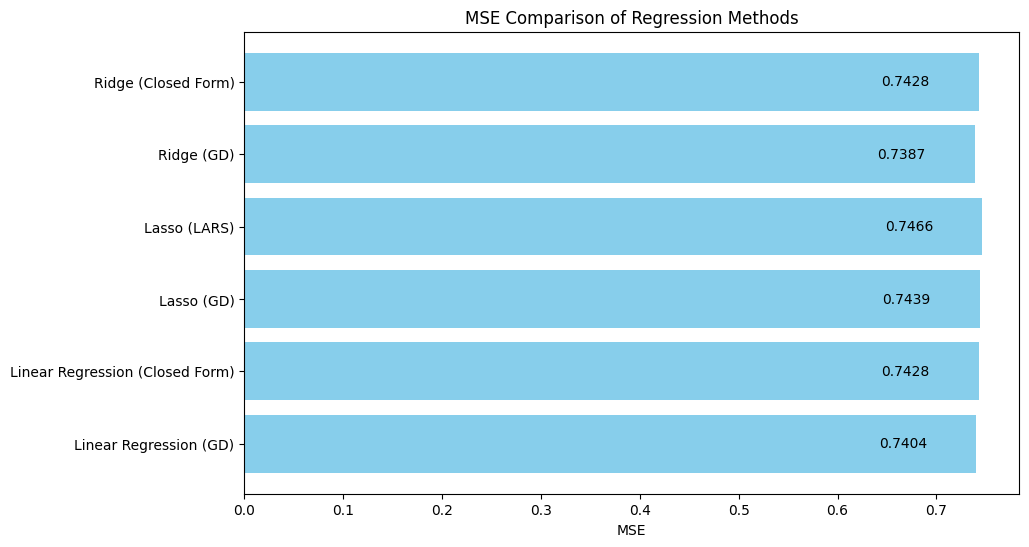

In [ ]:
import matplotlib.pyplot as plt

# Example MSE values from each method
mse_values = {
    'Linear Regression (GD)': mse_linear,  # Replace with actual MSE
    'Linear Regression (Closed Form)': mse_linear_closed,
    'Lasso (GD)': lasso_mse,
    'Lasso (LARS)': lasso_lars_mse,
    'Ridge (GD)': ridge_mse,
    'Ridge (Closed Form)': ridge_mse_closed
}

# Plotting the MSE comparison
methods = list(mse_values.keys())
mse_scores = list(mse_values.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(methods, mse_scores, color='skyblue')

# Annotating the bars with MSE values
for bar in bars:
    plt.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.4f}', va='center', ha='right', color='black', fontsize=10)

plt.xlabel('MSE')
plt.title('MSE Comparison of Regression Methods')
plt.show()

### **Regression NonLinear Models**

#### **Polynomial Regression**

#### **Without Regulization**

Degree 1:
  Training MSE: 0.5419, MAE: 0.4451, R²: 0.0610
  Validation MSE: 1.1483, MAE: 0.4647, R²: 0.0341
----------------------------------------
Degree 2:
  Training MSE: 0.4883, MAE: 0.4237, R²: 0.1539
  Validation MSE: 1.0878, MAE: 0.4453, R²: 0.0850
----------------------------------------
Degree 3:
  Training MSE: 0.3148, MAE: 0.3173, R²: 0.4546
  Validation MSE: 0.8861, MAE: 0.3459, R²: 0.2546
----------------------------------------
Degree 4:
  Training MSE: 0.2063, MAE: 0.2507, R²: 0.6425
  Validation MSE: 0.6755, MAE: 0.2802, R²: 0.4318
----------------------------------------
Degree 5:
  Training MSE: 0.1592, MAE: 0.2136, R²: 0.7241
  Validation MSE: 0.5054, MAE: 0.2385, R²: 0.5749
----------------------------------------
Degree 6:
  Training MSE: 0.1337, MAE: 0.1971, R²: 0.7682
  Validation MSE: 0.3690, MAE: 0.2245, R²: 0.6897
----------------------------------------
Degree 7:
  Training MSE: 0.1133, MAE: 0.1806, R²: 0.8037
  Validation MSE: 0.2645, MAE: 0.2086, R²: 0.777

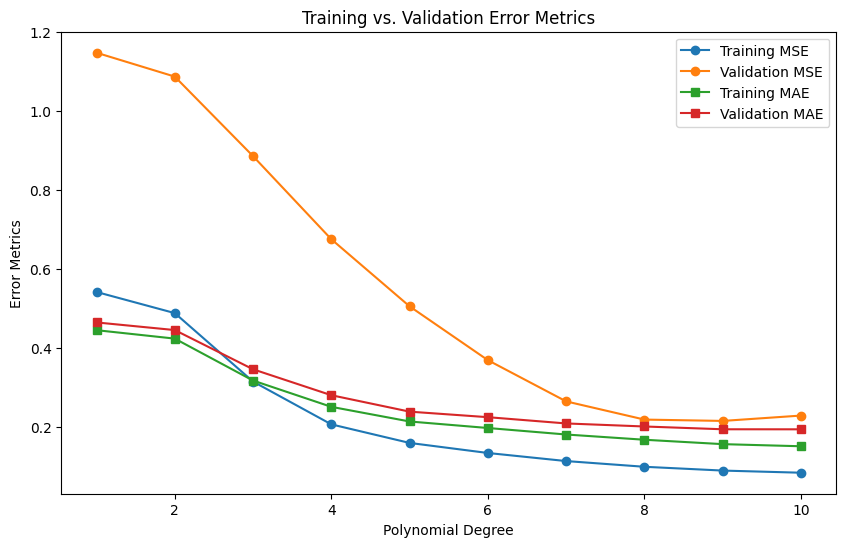

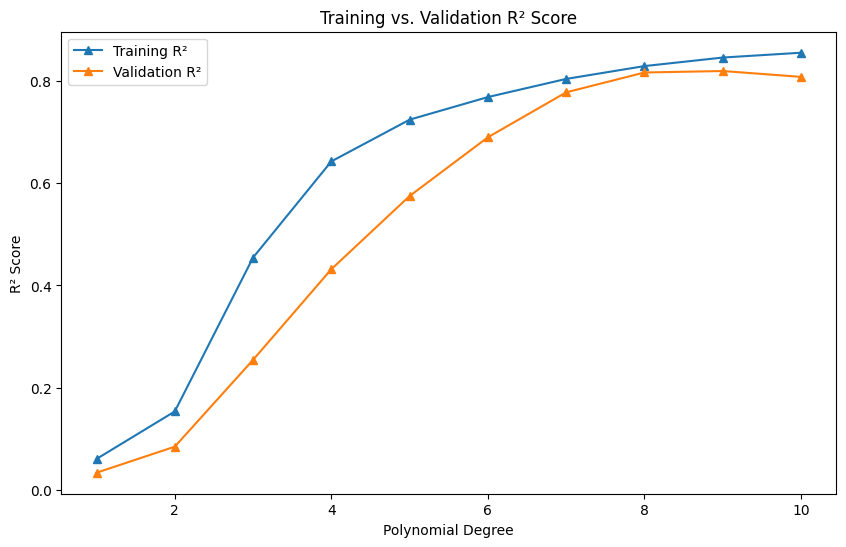

In [17]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

degrees = range(1, 11)  # Polynomial degrees to test
mse_values_train = []
mse_values_val = []
mae_values_train = []
mae_values_val = []
r2_values_train = []
r2_values_val = []

for degree in degrees:
    # Polynomial transformation
    poly = PolynomialFeatures(degree)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)

    # Scale polynomial features
    scaler = StandardScaler()
    features_train_poly_scaled = scaler.fit_transform(features_train_poly)
    features_val_poly_scaled = scaler.transform(features_val_poly)

    # Convert to TensorFlow tensors
    features_train_tensor = tf.constant(features_train_poly_scaled, dtype=tf.float32)
    target_train_tensor = tf.constant(target_train, dtype=tf.float32)
    features_val_tensor = tf.constant(features_val_poly_scaled, dtype=tf.float32)
    target_val_tensor = tf.constant(target_val, dtype=tf.float32)

    # Initialize weights (reset for each degree)
    weights = tf.Variable(tf.zeros([features_train_poly.shape[1]], dtype=tf.float32))

    # Learning rate and optimizer
    learning_rate = 1e-5  # Lower the learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Use Adam optimizer

    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            target_train_pred = tf.linalg.matvec(features_train_tensor, weights)
            train_loss = tf.reduce_mean(tf.square(target_train_pred - target_train_tensor))  # MSE loss for training

            # Add L2 regularization
            regularization_strength = 0.01
            train_loss += regularization_strength * tf.reduce_sum(tf.square(weights))

        # Compute and apply gradients
        gradients = tape.gradient(train_loss, [weights])
        clipped_gradients = [tf.clip_by_value(grad, -0.1, 0.1) for grad in gradients]  # Clipping gradients more tightly
        optimizer.apply_gradients(zip(clipped_gradients, [weights]))

        # Debugging: Check for NaN in weights
        if np.isnan(weights.numpy()).any():
            print(f"NaN encountered in weights at epoch {epoch}")
            break

    # After training, evaluate on both datasets
    target_train_pred = tf.linalg.matvec(features_train_tensor, weights).numpy()
    target_val_pred = tf.linalg.matvec(features_val_tensor, weights).numpy()

    # Calculate metrics for training
    mse_train = mean_squared_error(target_train, target_train_pred)
    mae_train = mean_absolute_error(target_train, target_train_pred)
    r2_train = r2_score(target_train, target_train_pred)

    # Calculate metrics for validation
    mse_val = mean_squared_error(target_val, target_val_pred)
    mae_val = mean_absolute_error(target_val, target_val_pred)
    r2_val = r2_score(target_val, target_val_pred)

    mse_values_train.append(mse_train)
    mse_values_val.append(mse_val)
    mae_values_train.append(mae_train)
    mae_values_val.append(mae_val)
    r2_values_train.append(r2_train)
    r2_values_val.append(r2_val)

    # Print the metrics for this degree
    print(f"Degree {degree}:")
    print(f"  Training MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
    print(f"  Validation MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")
    print("-" * 40)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_values_train, label="Training MSE", marker='o')
plt.plot(degrees, mse_values_val, label="Validation MSE", marker='o')
plt.plot(degrees, mae_values_train, label="Training MAE", marker='s')
plt.plot(degrees, mae_values_val, label="Validation MAE", marker='s')
plt.xlabel("Polynomial Degree")
plt.ylabel("Error Metrics")
plt.title("Training vs. Validation Error Metrics")
plt.legend()
plt.show()

# Plot R² values
plt.figure(figsize=(10, 6))
plt.plot(degrees, r2_values_train, label="Training R²", marker='^')
plt.plot(degrees, r2_values_val, label="Validation R²", marker='^')
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.title("Training vs. Validation R² Score")
plt.legend()
plt.show()


# **Radial Basis Function (RBF)**


Degree 2:
  C=0.1, epsilon=0.01: MSE = 0.8976, MAE = 0.2032, R² = 0.2450
  C=0.1, epsilon=0.1: MSE = 0.8928, MAE = 0.2098, R² = 0.2490
  C=0.1, epsilon=0.5: MSE = 0.9275, MAE = 0.3602, R² = 0.2198
  C=1.0, epsilon=0.01: MSE = 0.8035, MAE = 0.1603, R² = 0.3242
  C=1.0, epsilon=0.1: MSE = 0.7972, MAE = 0.1678, R² = 0.3294
  C=1.0, epsilon=0.5: MSE = 0.8202, MAE = 0.2968, R² = 0.3101
  C=10.0, epsilon=0.01: MSE = 0.7798, MAE = 0.1400, R² = 0.3441
  C=10.0, epsilon=0.1: MSE = 0.7718, MAE = 0.1546, R² = 0.3508
  C=10.0, epsilon=0.5: MSE = 0.8033, MAE = 0.2834, R² = 0.3243

Degree 3:
  C=0.1, epsilon=0.01: MSE = 0.9187, MAE = 0.2138, R² = 0.2273
  C=0.1, epsilon=0.1: MSE = 0.9142, MAE = 0.2213, R² = 0.2310
  C=0.1, epsilon=0.5: MSE = 0.9540, MAE = 0.3839, R² = 0.1975
  C=1.0, epsilon=0.01: MSE = 0.8135, MAE = 0.1657, R² = 0.3157
  C=1.0, epsilon=0.1: MSE = 0.8082, MAE = 0.1733, R² = 0.3202
  C=1.0, epsilon=0.5: MSE = 0.8470, MAE = 0.3270, R² = 0.2876
  C=10.0, epsilon=0.01: MSE = 0.7930, MA

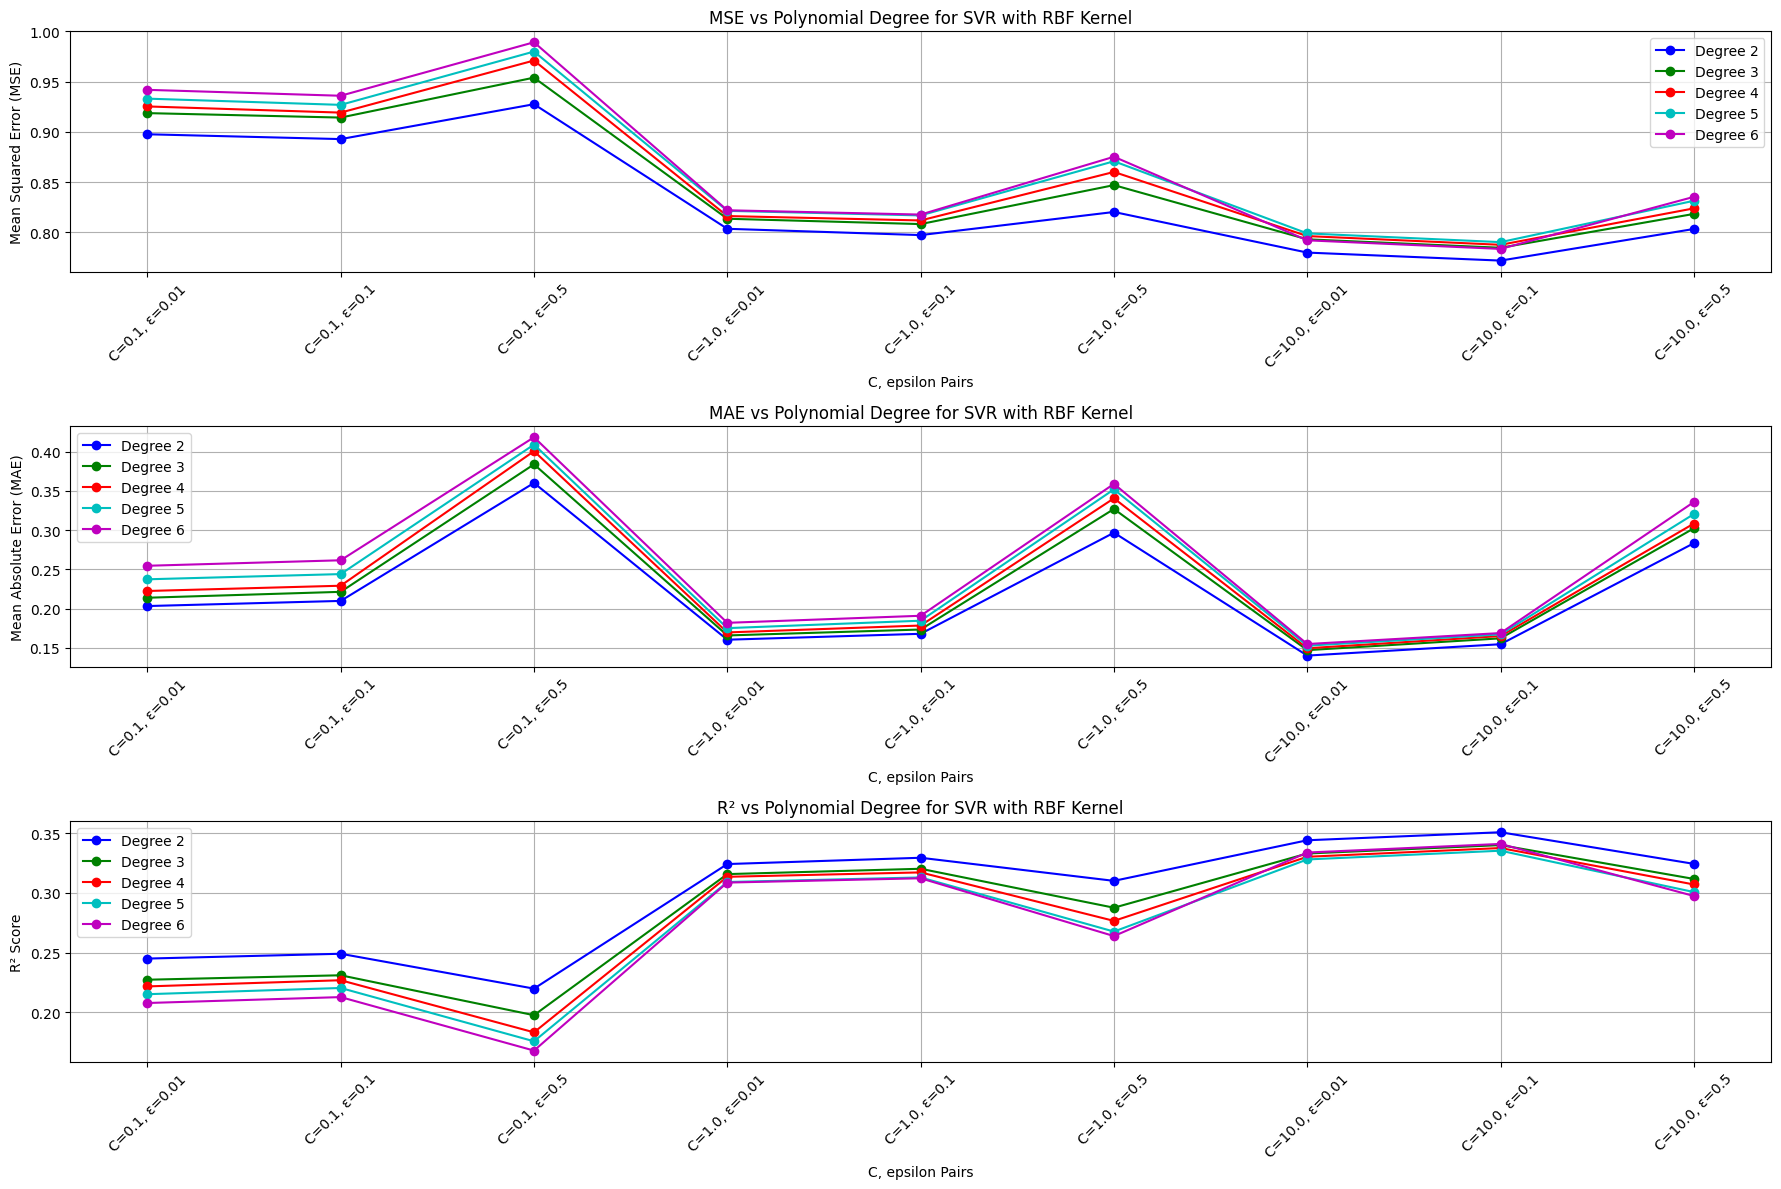

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define a function for polynomial regression with RBF kernel
def svr_with_polynomial(features_train, target_train, features_val, target_val, degree=2, C=1.0, epsilon=0.1, kernel='rbf'):
    # Apply polynomial transformation
    poly = PolynomialFeatures(degree)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)

    # Scale the features
    scaler = StandardScaler()
    features_train_poly_scaled = scaler.fit_transform(features_train_poly)
    features_val_poly_scaled = scaler.transform(features_val_poly)

    # Initialize and train the SVR model with RBF kernel
    svr_model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    svr_model.fit(features_train_poly_scaled, target_train)

    # Make predictions on the validation set
    target_pred = svr_model.predict(features_val_poly_scaled)

    # Calculate MSE, MAE, and R²
    mse = mean_squared_error(target_val, target_pred)
    mae = mean_absolute_error(target_val, target_pred)
    r2 = r2_score(target_val, target_pred)

    return svr_model, mse, mae, r2

# Vary polynomial degree and test metrics across different degrees
degree_values = range(2, 7)  # Polynomial degrees from 2 to 5
C_values = [0.1, 1.0, 10.0]  # C values to test
epsilon_values = [0.01, 0.1, 0.5]  # Epsilon values to test
metrics_values = {}  # Store MSE, MAE, and R² for each configuration

# Test the effect of polynomial degree, C, and epsilon
for degree in degree_values:
    metrics_values[degree] = {}
    for C in C_values:
        for epsilon in epsilon_values:
            _, mse, mae, r2 = svr_with_polynomial(features_train, target_train, features_val, target_val, degree=degree, C=C, epsilon=epsilon)
            metrics_values[degree][(C, epsilon)] = (mse, mae, r2)

# Print metrics values for all combinations of degree, C, and epsilon
for degree in degree_values:
    print(f"\nDegree {degree}:")
    for (C, epsilon), (mse, mae, r2) in metrics_values[degree].items():
        print(f"  C={C}, epsilon={epsilon}: MSE = {mse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

# Plot MSE, MAE, and R² vs polynomial degree, C, and epsilon
plt.figure(figsize=(18, 12))

# Colors for different degrees
colors = ['b', 'g', 'r', 'c', 'm']

# Plot MSE
plt.subplot(3, 1, 1)
for idx, degree in enumerate(degree_values):
    C_epsilon_pairs = list(metrics_values[degree].keys())
    mse_for_degree = [metrics_values[degree][pair][0] for pair in C_epsilon_pairs]  # Extract MSE
    plt.plot(range(len(C_epsilon_pairs)), mse_for_degree, marker='o', linestyle='-', color=colors[idx], label=f'Degree {degree}')
plt.title('MSE vs Polynomial Degree for SVR with RBF Kernel')
plt.xlabel('C, epsilon Pairs')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(range(len(C_values) * len(epsilon_values)), [f'C={C}, ε={epsilon}' for C in C_values for epsilon in epsilon_values], rotation=45)
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(3, 1, 2)
for idx, degree in enumerate(degree_values):
    C_epsilon_pairs = list(metrics_values[degree].keys())
    mae_for_degree = [metrics_values[degree][pair][1] for pair in C_epsilon_pairs]  # Extract MAE
    plt.plot(range(len(C_epsilon_pairs)), mae_for_degree, marker='o', linestyle='-', color=colors[idx], label=f'Degree {degree}')
plt.title('MAE vs Polynomial Degree for SVR with RBF Kernel')
plt.xlabel('C, epsilon Pairs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(range(len(C_values) * len(epsilon_values)), [f'C={C}, ε={epsilon}' for C in C_values for epsilon in epsilon_values], rotation=45)
plt.legend()
plt.grid(True)

# Plot R²
plt.subplot(3, 1, 3)
for idx, degree in enumerate(degree_values):
    C_epsilon_pairs = list(metrics_values[degree].keys())
    r2_for_degree = [metrics_values[degree][pair][2] for pair in C_epsilon_pairs]  # Extract R²
    plt.plot(range(len(C_epsilon_pairs)), r2_for_degree, marker='o', linestyle='-', color=colors[idx], label=f'Degree {degree}')
plt.title('R² vs Polynomial Degree for SVR with RBF Kernel')
plt.xlabel('C, epsilon Pairs')
plt.ylabel('R² Score')
plt.xticks(range(len(C_values) * len(epsilon_values)), [f'C={C}, ε={epsilon}' for C in C_values for epsilon in epsilon_values], rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Polynomial Regression with Ridge Regularization and Performance Evaluation**


Degree 1:
  Train MSE: 0.5419, Validation MSE: 1.1483
  Train MAE: 0.4451, Validation MAE: 0.4647
  Train R-squared: 0.0610, Validation R-squared: 0.0341

Degree 2:
  Train MSE: 0.4884, Validation MSE: 1.0879
  Train MAE: 0.4237, Validation MAE: 0.4454
  Train R-squared: 0.1537, Validation R-squared: 0.0849

Degree 3:
  Train MSE: 0.3150, Validation MSE: 0.8866
  Train MAE: 0.3175, Validation MAE: 0.3460
  Train R-squared: 0.4543, Validation R-squared: 0.2542

Degree 4:
  Train MSE: 0.2067, Validation MSE: 0.6775
  Train MAE: 0.2509, Validation MAE: 0.2803
  Train R-squared: 0.6417, Validation R-squared: 0.4301

Degree 5:
  Train MSE: 0.1599, Validation MSE: 0.5117
  Train MAE: 0.2139, Validation MAE: 0.2390
  Train R-squared: 0.7229, Validation R-squared: 0.5695

Degree 6:
  Train MSE: 0.1348, Validation MSE: 0.3815
  Train MAE: 0.1977, Validation MAE: 0.2250
  Train R-squared: 0.7664, Validation R-squared: 0.6791

Degree 7:
  Train MSE: 0.1148, Validation MSE: 0.2802
  Train MAE: 0.

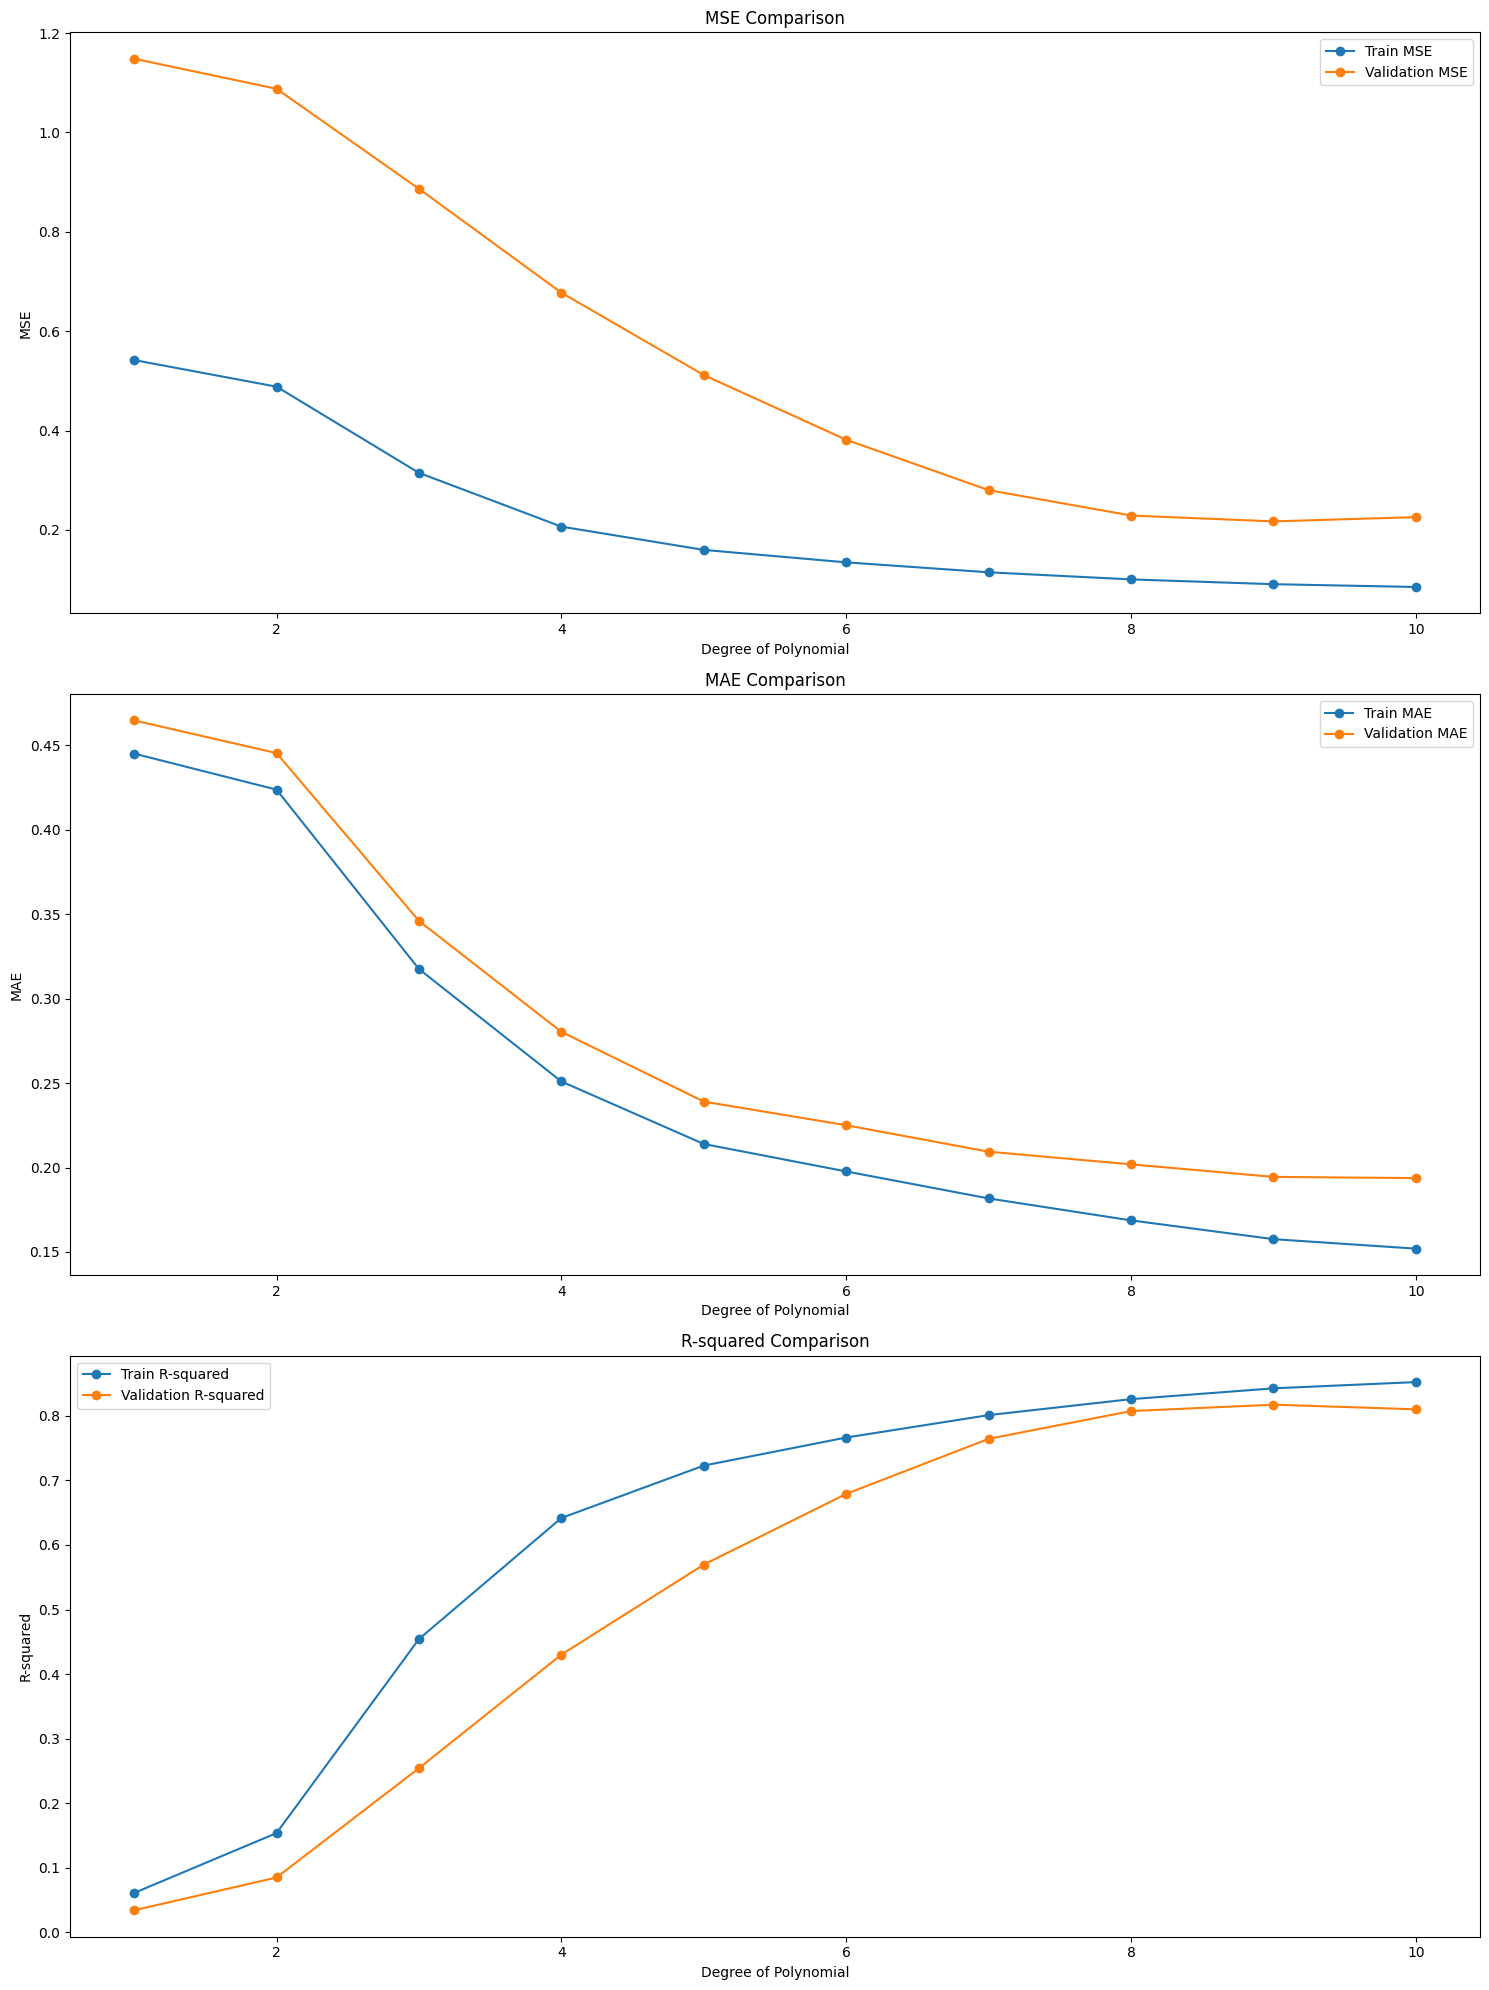

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming features_train, target_train, features_val, target_val are preprocessed and split

degrees = range(1, 11)  # Polynomial degrees to test
mse_values_train_ridge = []
mse_values_val_ridge = []
mae_values_train_ridge = []
mae_values_val_ridge = []
r2_values_train_ridge = []
r2_values_val_ridge = []

for degree in degrees:
    # Polynomial transformation
    poly = PolynomialFeatures(degree)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)

    # Scale polynomial features
    scaler = StandardScaler()
    features_train_poly_scaled = scaler.fit_transform(features_train_poly)
    features_val_poly_scaled = scaler.transform(features_val_poly)

    # Convert to TensorFlow tensors
    features_train_tensor = tf.constant(features_train_poly_scaled, dtype=tf.float32)
    target_train_tensor = tf.constant(target_train, dtype=tf.float32)
    features_val_tensor = tf.constant(features_val_poly_scaled, dtype=tf.float32)
    target_val_tensor = tf.constant(target_val, dtype=tf.float32)

    # Initialize weights (reset for each degree)
    weights = tf.Variable(tf.zeros([features_train_poly.shape[1]], dtype=tf.float32))

    # Learning rate and optimizer
    learning_rate = 1e-5  # Lower the learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Use Adam optimizer

    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            target_train_pred = tf.linalg.matvec(features_train_tensor, weights)
            train_loss = tf.reduce_mean(tf.square(target_train_pred - target_train_tensor))  # MSE loss for training

            # Add L2 regularization
            regularization_strength = alpha_ridge
            train_loss += regularization_strength * tf.reduce_sum(tf.square(weights))

        # Compute and apply gradients
        gradients = tape.gradient(train_loss, [weights])
        clipped_gradients = [tf.clip_by_value(grad, -0.1, 0.1) for grad in gradients]  # Clipping gradients more tightly
        optimizer.apply_gradients(zip(clipped_gradients, [weights]))

        # Debugging: Check for NaN in weights
        if np.isnan(weights.numpy()).any():
            print(f"NaN encountered in weights at epoch {epoch}")
            break

    # After training, evaluate on both datasets
    target_train_pred = tf.linalg.matvec(features_train_tensor, weights).numpy()
    target_val_pred = tf.linalg.matvec(features_val_tensor, weights).numpy()

    # Calculate MSE, MAE, and R-squared for training and validation
    mse_train = mean_squared_error(target_train, target_train_pred)
    mse_val = mean_squared_error(target_val, target_val_pred)
    mae_train = mean_absolute_error(target_train, target_train_pred)
    mae_val = mean_absolute_error(target_val, target_val_pred)
    r2_train = r2_score(target_train, target_train_pred)
    r2_val = r2_score(target_val, target_val_pred)

    mse_values_train_ridge.append(mse_train)
    mse_values_val_ridge.append(mse_val)
    mae_values_train_ridge.append(mae_train)
    mae_values_val_ridge.append(mae_val)
    r2_values_train_ridge.append(r2_train)
    r2_values_val_ridge.append(r2_val)

    # Print the results for each degree
    print(f"\nDegree {degree}:")
    print(f"  Train MSE: {mse_train:.4f}, Validation MSE: {mse_val:.4f}")
    print(f"  Train MAE: {mae_train:.4f}, Validation MAE: {mae_val:.4f}")
    print(f"  Train R-squared: {r2_train:.4f}, Validation R-squared: {r2_val:.4f}")

# Plotting the metrics for different polynomial degrees
plt.figure(figsize=(15, 20))

# MSE Plot
plt.subplot(3, 1, 1)
plt.plot(degrees, mse_values_train_ridge, label='Train MSE', marker='o')
plt.plot(degrees, mse_values_val_ridge, label='Validation MSE', marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('MSE')
plt.title('MSE Comparison')
plt.legend()

# MAE Plot
plt.subplot(3, 1, 2)
plt.plot(degrees, mae_values_train_ridge, label='Train MAE', marker='o')
plt.plot(degrees, mae_values_val_ridge, label='Validation MAE', marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('MAE')
plt.title('MAE Comparison')
plt.legend()

# R-squared Plot
plt.subplot(3, 1, 3)
plt.plot(degrees, r2_values_train_ridge, label='Train R-squared', marker='o')
plt.plot(degrees, r2_values_val_ridge, label='Validation R-squared', marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('R-squared')
plt.title('R-squared Comparison')
plt.legend()

plt.tight_layout()
plt.show()


# **Impact of Polynomial Degree on Lasso Regression Model Performance**

Degree 1:
  Training MSE: 0.5420, Validation MSE: 1.1483
  Training MAE: 0.4451, Validation MAE: 0.4648
  Training R²: 0.0609, Validation R²: 0.0341
--------------------------------------------------
Degree 2:
  Training MSE: 0.4887, Validation MSE: 1.0874
  Training MAE: 0.4240, Validation MAE: 0.4455
  Training R²: 0.1532, Validation R²: 0.0853
--------------------------------------------------
Degree 3:
  Training MSE: 0.3159, Validation MSE: 0.8885
  Training MAE: 0.3187, Validation MAE: 0.3465
  Training R²: 0.4526, Validation R²: 0.2527
--------------------------------------------------
Degree 4:
  Training MSE: 0.2116, Validation MSE: 0.6939
  Training MAE: 0.2540, Validation MAE: 0.2814
  Training R²: 0.6334, Validation R²: 0.4163
--------------------------------------------------
Degree 5:
  Training MSE: 0.1700, Validation MSE: 0.5748
  Training MAE: 0.2213, Validation MAE: 0.2463
  Training R²: 0.7054, Validation R²: 0.5165
--------------------------------------------------


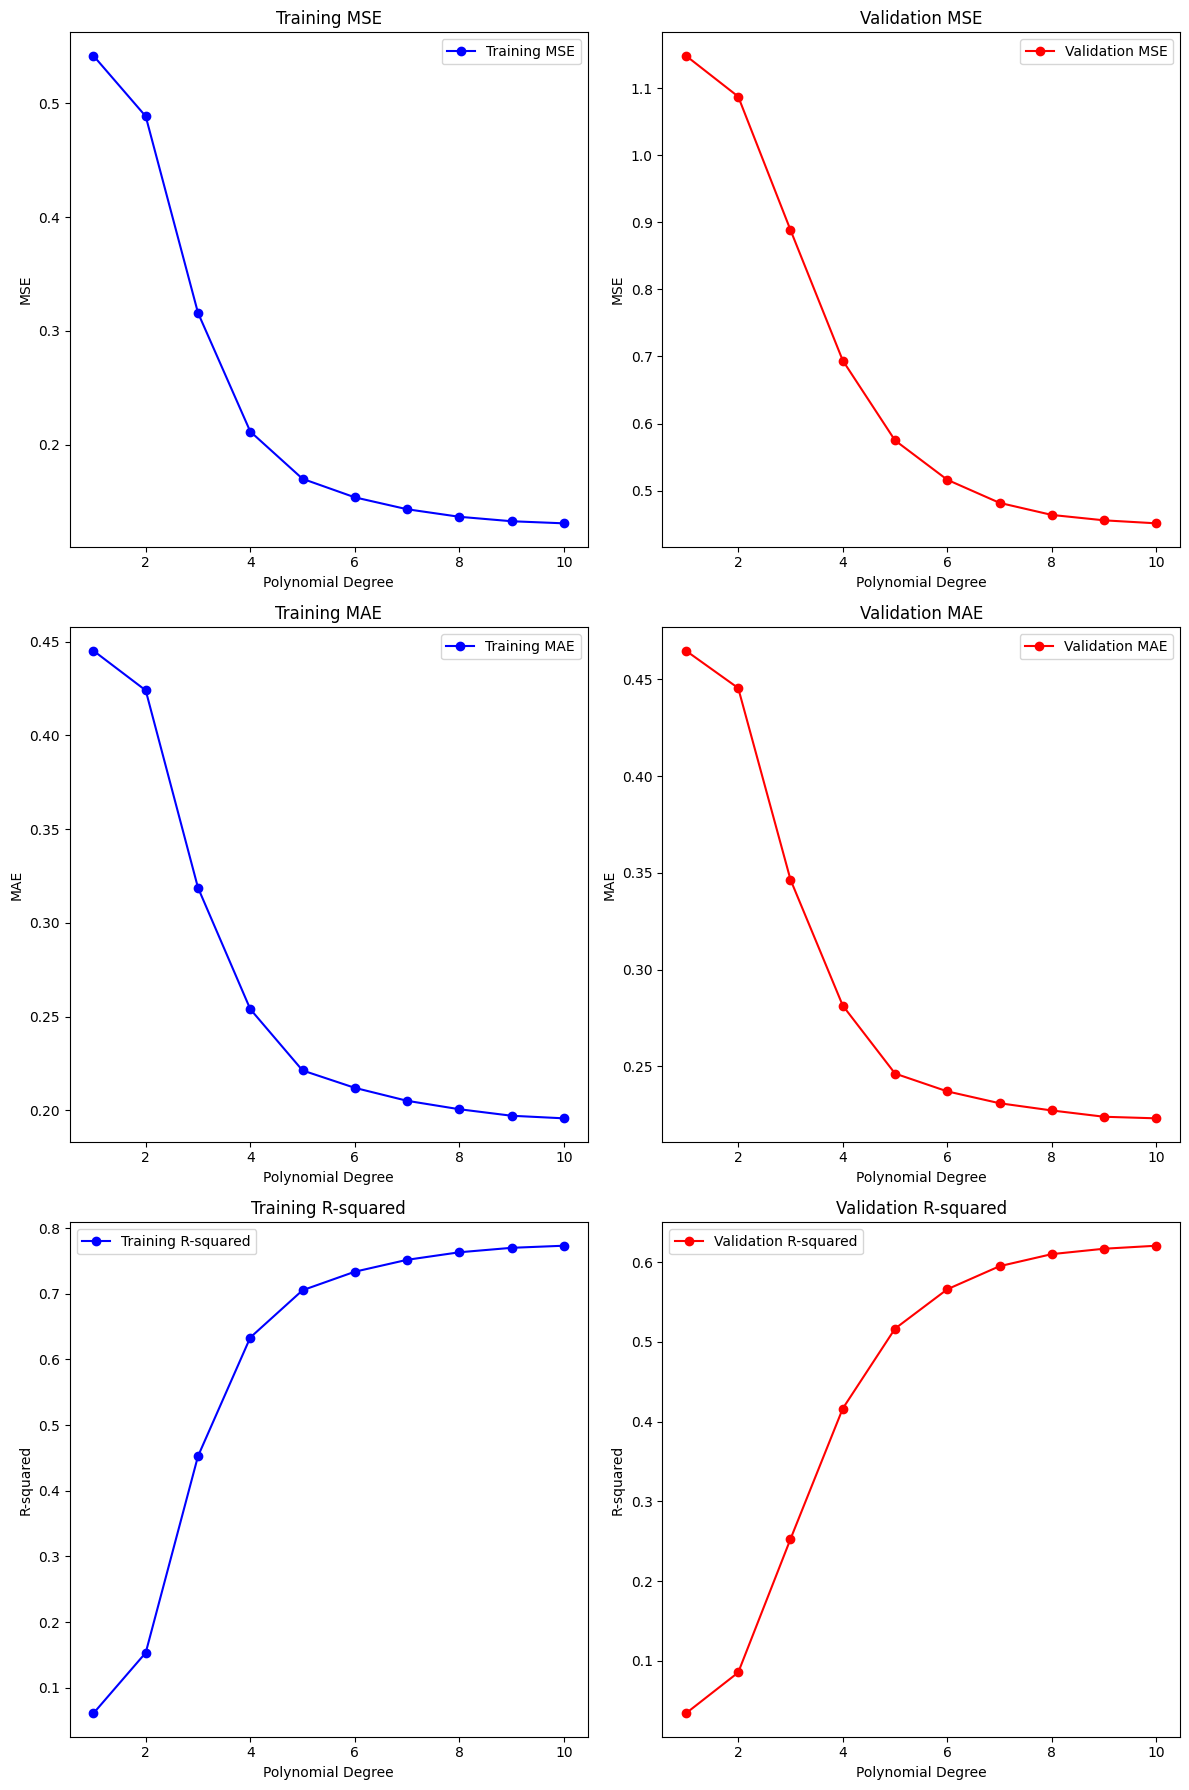

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping  # استيراد EarlyStopping

# Assuming features_train, target_train, features_val, target_val are preprocessed and split

degrees = range(1, 11)  # Polynomial degrees to test
mse_values_train_lasso = []
mse_values_val_lasso = []
mae_values_train_lasso = []
mae_values_val_lasso = []
r2_values_train_lasso = []
r2_values_val_lasso = []

for degree in degrees:
    # Polynomial transformation
    poly = PolynomialFeatures(degree)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)

    # Scale polynomial features
    scaler = StandardScaler()
    features_train_poly_scaled = scaler.fit_transform(features_train_poly)
    features_val_poly_scaled = scaler.transform(features_val_poly)

    # Convert to TensorFlow tensors
    features_train_tensor = tf.constant(features_train_poly_scaled, dtype=tf.float32)
    target_train_tensor = tf.constant(target_train, dtype=tf.float32)
    features_val_tensor = tf.constant(features_val_poly_scaled, dtype=tf.float32)
    target_val_tensor = tf.constant(target_val, dtype=tf.float32)

    # Initialize weights (reset for each degree)
    weights = tf.Variable(tf.zeros([features_train_poly.shape[1]], dtype=tf.float32))

    # Learning rate and optimizer
    learning_rate = 0.00001  # Lower the learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Use Adam optimizer

    # Early stopping setup
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)  # 50 epochs patience

    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            target_train_pred = tf.linalg.matvec(features_train_tensor, weights)
            train_loss = tf.reduce_mean(tf.square(target_train_pred - target_train_tensor))  # MSE loss for training

            # Add L1 regularization (Lasso)
            regularization_strength = alpha_lasso
            train_loss += regularization_strength * tf.reduce_sum(tf.abs(weights))  # L1 regularization

        # Compute and apply gradients
        gradients = tape.gradient(train_loss, [weights])
        clipped_gradients = [tf.clip_by_value(grad, -0.1, 0.1) for grad in gradients]  # Clipping gradients more tightly
        optimizer.apply_gradients(zip(clipped_gradients, [weights]))

        # Check if early stopping should be applied
        if early_stopping.stopped_epoch > 0:
            print(f"Early stopping at epoch {epoch}")
            break

    # After training, evaluate on both datasets
    target_train_pred = tf.linalg.matvec(features_train_tensor, weights).numpy()
    target_val_pred = tf.linalg.matvec(features_val_tensor, weights).numpy()

    # Calculate MSE, MAE, and R-squared for training and validation
    mse_train = mean_squared_error(target_train, target_train_pred)
    mse_val = mean_squared_error(target_val, target_val_pred)
    mae_train = mean_absolute_error(target_train, target_train_pred)
    mae_val = mean_absolute_error(target_val, target_val_pred)
    r2_train = r2_score(target_train, target_train_pred)
    r2_val = r2_score(target_val, target_val_pred)

    mse_values_train_lasso.append(mse_train)
    mse_values_val_lasso.append(mse_val)
    mae_values_train_lasso.append(mae_train)
    mae_values_val_lasso.append(mae_val)
    r2_values_train_lasso.append(r2_train)
    r2_values_val_lasso.append(r2_val)

    # Print the results for the current polynomial degree
    print(f"Degree {degree}:")
    print(f"  Training MSE: {mse_train:.4f}, Validation MSE: {mse_val:.4f}")
    print(f"  Training MAE: {mae_train:.4f}, Validation MAE: {mae_val:.4f}")
    print(f"  Training R²: {r2_train:.4f}, Validation R²: {r2_val:.4f}")
    print("-" * 50)

# Plotting the metrics for different polynomial degrees
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# MSE Plot
axes[0, 0].plot(degrees, mse_values_train_lasso, label="Training MSE", marker='o', color='blue')
axes[0, 1].plot(degrees, mse_values_val_lasso, label="Validation MSE", marker='o', color='red')
axes[0, 0].set_xlabel("Polynomial Degree")
axes[0, 0].set_ylabel("MSE")
axes[0, 1].set_xlabel("Polynomial Degree")
axes[0, 1].set_ylabel("MSE")
axes[0, 0].set_title("Training MSE")
axes[0, 1].set_title("Validation MSE")
axes[0, 0].legend()
axes[0, 1].legend()

# MAE Plot
axes[1, 0].plot(degrees, mae_values_train_lasso, label="Training MAE", marker='o', color='blue')
axes[1, 1].plot(degrees, mae_values_val_lasso, label="Validation MAE", marker='o', color='red')
axes[1, 0].set_xlabel("Polynomial Degree")
axes[1, 0].set_ylabel("MAE")
axes[1, 1].set_xlabel("Polynomial Degree")
axes[1, 1].set_ylabel("MAE")
axes[1, 0].set_title("Training MAE")
axes[1, 1].set_title("Validation MAE")
axes[1, 0].legend()
axes[1, 1].legend()

# R-squared Plot
axes[2, 0].plot(degrees, r2_values_train_lasso, label="Training R-squared", marker='o', color='blue')
axes[2, 1].plot(degrees, r2_values_val_lasso, label="Validation R-squared", marker='o', color='red')
axes[2, 0].set_xlabel("Polynomial Degree")
axes[2, 0].set_ylabel("R-squared")
axes[2, 1].set_xlabel("Polynomial Degree")
axes[2, 1].set_ylabel("R-squared")
axes[2, 0].set_title("Training R-squared")
axes[2, 1].set_title("Validation R-squared")
axes[2, 0].legend()
axes[2, 1].legend()

plt.tight_layout()
plt.show()


# **Feature Selection**

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Assuming features_train, target_train, features_val, target_val are preprocessed

def forward_selection_poly(features_train, target_train, features_val, target_val, degree, initial_weights, max_features):
    features_indices = list(range(features_train.shape[1]))  # Indices of features
    selected_features = []
    best_mse = float('inf')  # Start with a high error value

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)

    # Scale the features
    scaler = StandardScaler()
    features_train_poly = scaler.fit_transform(features_train_poly)
    features_val_poly = scaler.transform(features_val_poly)

    while features_indices and len(selected_features) < max_features:
        mse_with_feature = {}

        for feature in features_indices:
            current_features = selected_features + [feature]

            # Extract corresponding polynomial terms
            features_train_selected = features_train_poly[:, current_features]
            features_val_selected = features_val_poly[:, current_features]

            # Initialize weights for selected features (random initialization)
            initial_weights_subset = np.random.randn(len(current_features))
            initial_weights_subset = tf.Variable(initial_weights_subset, dtype=tf.float32)

            # Training loop
            weights = tf.Variable(initial_weights_subset)
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Increase learning rate
            epochs = 1500  # Increase number of epochs

            for _ in range(epochs):
                with tf.GradientTape() as tape:
                    # Perform matrix multiplication and calculate predictions
                    target_train_pred = tf.linalg.matvec(features_train_selected, weights)

                    # Compute the loss (mean squared error)
                    loss = tf.reduce_mean((target_train_pred - target_train) ** 2)

                gradients = tape.gradient(loss, [weights])
                optimizer.apply_gradients(zip(gradients, [weights]))

            # Evaluate MSE on validation set
            target_val_pred = tf.linalg.matvec(features_val_selected, weights).numpy()
            mse = mean_squared_error(target_val, target_val_pred)
            mse_with_feature[feature] = mse

        # Select the feature that gives the lowest MSE
        best_feature = min(mse_with_feature, key=mse_with_feature.get)

        if mse_with_feature[best_feature] < best_mse:
            best_mse = mse_with_feature[best_feature]
            selected_features.append(best_feature)
            features_indices.remove(best_feature)
            print(f"Added feature {best_feature} with MSE: {best_mse:.4f}")
        else:
            # Stop if no feature improves the model
            print("No feature improves the model. Stopping selection.")
            break

    return selected_features

# Ensure inputs are of dtype float32
features_train = features_train.astype(np.float32)
target_train = target_train.astype(np.float32)
features_val = features_val.astype(np.float32)
target_val = target_val.astype(np.float32)

# Random initialization of weights
initial_weights = np.random.randn(features_train.shape[1])  # Random initialization

# Call the function with degree 4, initial weights, and a maximum of 5 features
max_features = 5  # Limit the number of features added to the model
selected_features = forward_selection_poly(features_train, target_train, features_val, target_val, degree=4, initial_weights=initial_weights, max_features=max_features)

# Print the selected features
print("Selected Features:", selected_features)


Added feature 4 with MSE: 0.7667
Added feature 8 with MSE: 0.4835
No feature improves the model. Stopping selection.
Selected Features: [4, 8]


In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

# Assuming features_train, target_train, features_val, target_val are preprocessed

def forward_selection_poly(features_train, target_train, features_val, target_val, degree, initial_weights, max_features):
    features_indices = list(range(features_train.shape[1]))  # Indices of features
    selected_features = []
    best_mse = float('inf')  # Start with a high error value

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)

    # Scale the features
    scaler = StandardScaler()
    features_train_poly = scaler.fit_transform(features_train_poly)
    features_val_poly = scaler.transform(features_val_poly)

    while features_indices and len(selected_features) < max_features:
        mse_with_feature = {}

        for feature in features_indices:
            current_features = selected_features + [feature]

            # Extract corresponding polynomial terms
            features_train_selected = features_train_poly[:, current_features]
            features_val_selected = features_val_poly[:, current_features]

            # Initialize weights for selected features (random initialization)
            initial_weights_subset = np.random.randn(len(current_features))
            initial_weights_subset = tf.Variable(initial_weights_subset, dtype=tf.float32)

            # Training loop
            weights = tf.Variable(initial_weights_subset)
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Increase learning rate
            epochs = 1500  # Increase number of epochs

            for _ in range(epochs):
                with tf.GradientTape() as tape:
                    # Perform matrix multiplication and calculate predictions
                    target_train_pred = tf.linalg.matvec(features_train_selected, weights)

                    # Compute the loss (mean squared error)
                    loss = tf.reduce_mean((target_train_pred - target_train) ** 2)

                gradients = tape.gradient(loss, [weights])
                optimizer.apply_gradients(zip(gradients, [weights]))

            # Evaluate MSE, MAE, and R-squared on validation set
            target_val_pred = tf.linalg.matvec(features_val_selected, weights).numpy()
            mse = mean_squared_error(target_val, target_val_pred)
            mae = mean_absolute_error(target_val, target_val_pred)
            r2 = r2_score(target_val, target_val_pred)

            mse_with_feature[feature] = {"MSE": mse, "MAE": mae, "R-squared": r2}

        # Select the feature that gives the lowest MSE
        best_feature = min(mse_with_feature, key=lambda x: mse_with_feature[x]["MSE"])

        if mse_with_feature[best_feature]["MSE"] < best_mse:
            best_mse = mse_with_feature[best_feature]["MSE"]
            selected_features.append(best_feature)
            features_indices.remove(best_feature)
            print(f"Added feature {best_feature} with MSE: {mse_with_feature[best_feature]['MSE']:.4f}, MAE: {mse_with_feature[best_feature]['MAE']:.4f}, R-squared: {mse_with_feature[best_feature]['R-squared']:.4f}")
        else:
            # Stop if no feature improves the model
            print("No feature improves the model. Stopping selection.")
            break

    return selected_features

# Ensure inputs are of dtype float32
features_train = features_train.astype(np.float32)
target_train = target_train.astype(np.float32)
features_val = features_val.astype(np.float32)
target_val = target_val.astype(np.float32)

# Random initialization of weights
initial_weights = np.random.randn(features_train.shape[1])  # Random initialization

# Call the function with degree 4, initial weights, and a maximum of 5 features
max_features = 5  # Limit the number of features added to the model
selected_features = forward_selection_poly(features_train, target_train, features_val, target_val, degree=4, initial_weights=initial_weights, max_features=max_features)

# Print the selected features
print("Selected Features:", selected_features)


# **Hyperparameter Tuning with Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume that you have features_train and target_train as your training data
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_train, target_train, test_size=0.2, random_state=42)

# Define models for grid search
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
}

# Define the range of hyperparameters (alphas for regularization, degrees for polynomial)
param_grids = {
    'Linear Regression': {},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
}

# Apply GridSearchCV for Linear Regression, Lasso, and Ridge
for model_name, model in models.items():
    print(f"Grid Search for {model_name}...")

    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids.get(model_name, {}), cv=None, scoring='neg_mean_squared_error')

    # Train the model using Grid Search with the training data
    grid_search.fit(X_train, y_train)

    # Display the best parameter (best α for regularized models)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Use the best model to predict on the training data
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)

    # Calculate MSE on the training data
    mse_train = mean_squared_error(y_train, y_train_pred)
    print(f"MSE on the training data for {model_name}: {mse_train}")

    # Predict on the validation (test) data
    y_val_pred = best_model.predict(X_val)

    # Calculate MSE on the validation data
    mse_val = mean_squared_error(y_val, y_val_pred)
    print(f"MSE on the validation data for {model_name}: {mse_val}")

# Polynomial Regression
print("\nPolynomial Regression...")
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Define polynomial regression model (using Linear Regression)
poly_model = LinearRegression()

# Apply Grid Search for Polynomial Regression
param_grid_poly = {'fit_intercept': [True, False]}  # Add hyperparameters for polynomial regression if necessary
grid_search_poly = GridSearchCV(estimator=poly_model, param_grid=param_grid_poly, cv=None, scoring='neg_mean_squared_error')

grid_search_poly.fit(X_train_poly, y_train)

# Display the best parameter
print(f"Best parameters for Polynomial Regression: {grid_search_poly.best_params_}")

# Use the best model to predict on the training data
best_poly_model = grid_search_poly.best_estimator_
y_train_poly_pred = best_poly_model.predict(X_train_poly)

# Calculate MSE on the training data
mse_train_poly = mean_squared_error(y_train, y_train_poly_pred)
print(f"MSE on the training data for Polynomial Regression: {mse_train_poly}")

# Predict on the validation data
y_val_poly_pred = best_poly_model.predict(X_val_poly)

# Calculate MSE on the validation data
mse_val_poly = mean_squared_error(y_val, y_val_poly_pred)
print(f"MSE on the validation data for Polynomial Regression: {mse_val_poly}")

# RBF (Radial Basis Function) model
print("\nRBF (Support Vector Machine)...")

# Define the RBF model (using Support Vector Regression)
rbf_model = SVR(kernel='rbf')

# Apply Grid Search for RBF model
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
grid_search_rbf = GridSearchCV(estimator=rbf_model, param_grid=param_grid_rbf, cv=None, scoring='neg_mean_squared_error')

grid_search_rbf.fit(X_train, y_train)

# Display the best parameter for RBF
print(f"Best parameters for RBF: {grid_search_rbf.best_params_}")

# Use the best model to predict on the training data
best_rbf_model = grid_search_rbf.best_estimator_
y_train_rbf_pred = best_rbf_model.predict(X_train)

# Calculate MSE on the training data
mse_train_rbf = mean_squared_error(y_train, y_train_rbf_pred)
print(f"MSE on the training data for RBF: {mse_train_rbf}")

# Predict on the validation (test) data
y_val_rbf_pred = best_rbf_model.predict(X_val)

# Calculate MSE on the validation data
mse_val_rbf = mean_squared_error(y_val, y_val_rbf_pred)
print(f"MSE on the validation data for RBF: {mse_val_rbf}")


Grid Search for Linear Regression...
Best parameters for Linear Regression: {}
MSE on the training data for Linear Regression: 0.16389787197113037
MSE on the validation data for Linear Regression: 0.46416664123535156
Grid Search for Lasso...
Best parameters for Lasso: {'alpha': 0.01}
MSE on the training data for Lasso: 0.16472302377223969
MSE on the validation data for Lasso: 0.4679167866706848
Grid Search for Ridge...
Best parameters for Ridge: {'alpha': 100}
MSE on the training data for Ridge: 0.16431625187397003
MSE on the validation data for Ridge: 0.4644809067249298

Polynomial Regression...
Best parameters for Polynomial Regression: {'fit_intercept': False}
MSE on the training data for Polynomial Regression: 0.08924441039562225
MSE on the validation data for Polynomial Regression: 0.3357982635498047

RBF (Support Vector Machine)...
Best parameters for RBF: {'C': 10, 'gamma': 'scale'}
MSE on the training data for RBF: 0.0462584467331685
MSE on the validation data for RBF: 0.295215

# **Model Evaluation on Test Set**

Test MSE: 0.4652
Test MAE: 0.2022
Test R²: 0.7761
Validation MSE: 0.2423
Validation MAE: 0.1690
Validation R²: 0.7962
Train MSE: 0.0751
Train MAE: 0.1958
Train R²: 0.7732


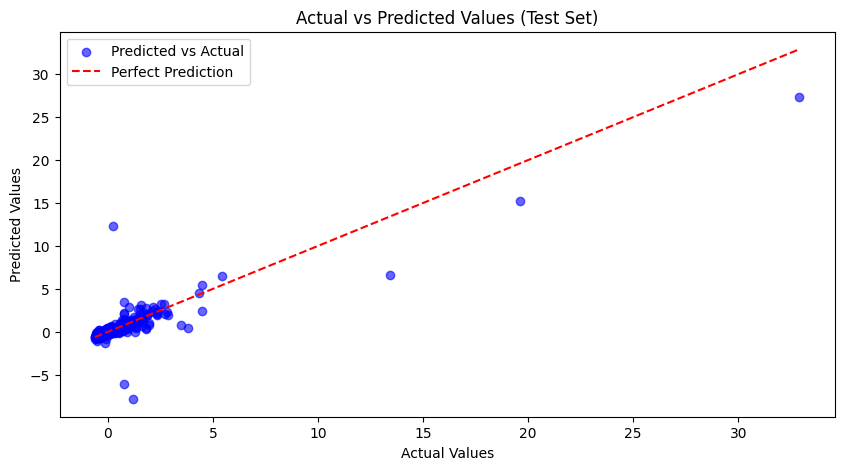

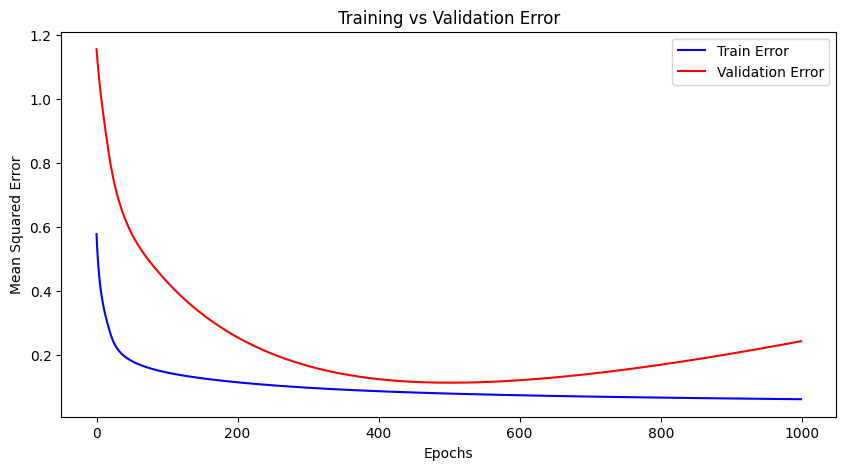

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming features_train, target_train, features_val, target_val, features_test, and target_test are preprocessed and split

# Polynomial degree 5 and feature selection done earlier
degree = 5
poly = PolynomialFeatures(degree)
features_train_poly = poly.fit_transform(features_train)
features_val_poly = poly.transform(features_val)
features_test_poly = poly.transform(features_test)

# Scaling the features
scaler = StandardScaler()
features_train_poly_scaled = scaler.fit_transform(features_train_poly)
features_val_poly_scaled = scaler.transform(features_val_poly)
features_test_poly_scaled = scaler.transform(features_test_poly)

# Convert to TensorFlow tensors
features_train_tensor = tf.constant(features_train_poly_scaled, dtype=tf.float32)
target_train_tensor = tf.constant(target_train, dtype=tf.float32)
features_val_tensor = tf.constant(features_val_poly_scaled, dtype=tf.float32)
target_val_tensor = tf.constant(target_val, dtype=tf.float32)
features_test_tensor = tf.constant(features_test_poly_scaled, dtype=tf.float32)
target_test_tensor = tf.constant(target_test, dtype=tf.float32)

# Initialize weights (using previous weights from degree 5 model)
weights = tf.Variable(tf.zeros([features_train_poly.shape[1]], dtype=tf.float32))  # weights from degree 5 model

# Gradient Descent
learning_rate = 0.0002
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize error lists
train_errors = []
val_errors = []

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        target_train_pred = tf.linalg.matvec(features_train_tensor, weights)
        train_loss = tf.reduce_mean(tf.square(target_train_pred - target_train_tensor))

    gradients = tape.gradient(train_loss, [weights])
    optimizer.apply_gradients(zip(gradients, [weights]))

    # Append the training error to the list
    train_errors.append(train_loss.numpy())

    # Compute validation loss
    target_val_pred = tf.linalg.matvec(features_val_tensor, weights)
    val_loss = tf.reduce_mean(tf.square(target_val_pred - target_val_tensor))

    # Append the validation error to the list
    val_errors.append(val_loss.numpy())

# Convert weights to float32 for compatibility with tensor operations
weights_float32 = tf.constant(weights.numpy(), dtype=tf.float32)

# Compute predictions on the test set
target_test_pred = tf.linalg.matvec(features_test_tensor, weights_float32).numpy()
target_val_pred = tf.linalg.matvec(features_val_tensor, weights_float32).numpy()

# Calculate evaluation metrics for the test set
mse_test = mean_squared_error(target_test, target_test_pred)
mae_test = mean_absolute_error(target_test, target_test_pred)
r2_test = r2_score(target_test, target_test_pred)

# Calculate evaluation metrics for the validation set
mse_val = mean_squared_error(target_val, target_val_pred)
mae_val = mean_absolute_error(target_val, target_val_pred)
r2_val = r2_score(target_val, target_val_pred)

# Display the results
print(f"Test MSE: {mse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Validation MSE: {mse_val:.4f}")
print(f"Validation MAE: {mae_val:.4f}")
print(f"Validation R²: {r2_val:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train R²: {r2_train:.4f}")

# Plot actual vs predicted values for test set
plt.figure(figsize=(10, 5))
plt.scatter(target_test, target_test_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(target_test), max(target_test)], [min(target_test), max(target_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.legend()
plt.show()

# Plot training vs validation error
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_errors, label='Train Error', color='blue')
plt.plot(range(epochs), val_errors, label='Validation Error', color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation Error')
plt.legend()
plt.show()


# **Optional**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Define features and the new target variable (top_speed)
features_train = cars_df[['engine_capacity', 'cylinder', 'horse_power', 'seats', 'price']]  # Select relevant features
target_variable2 = cars_df['top_speed']  # New target variable

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_train, target_variable2, test_size=0.2, random_state=42)

# Define models and parameter grids
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
}

param_grids = {
    'Linear Regression': {},  # No hyperparameters
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
}

# Perform Grid Search for each model
for model_name, model in models.items():
    print(f"Grid Search for {model_name}...")

    grid_search = GridSearchCV(estimator=model, param_grid=param_grids.get(model_name, {}), cv=None, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    print(f"MSE on the training data for {model_name}: {mse_train}")

    y_val_pred = best_model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    print(f"MSE on the validation data for {model_name}: {mse_val}")

# Polynomial Regression
print("\nPolynomial Regression...")
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

poly_model = LinearRegression()
param_grid_poly = {'fit_intercept': [True, False]}
grid_search_poly = GridSearchCV(estimator=poly_model, param_grid=param_grid_poly, cv=None, scoring='neg_mean_squared_error')
grid_search_poly.fit(X_train_poly, y_train)

print(f"Best parameters for Polynomial Regression: {grid_search_poly.best_params_}")

best_poly_model = grid_search_poly.best_estimator_
y_train_poly_pred = best_poly_model.predict(X_train_poly)
mse_train_poly = mean_squared_error(y_train, y_train_poly_pred)
print(f"MSE on the training data for Polynomial Regression: {mse_train_poly}")

y_val_poly_pred = best_poly_model.predict(X_val_poly)
mse_val_poly = mean_squared_error(y_val, y_val_poly_pred)
print(f"MSE on the validation data for Polynomial Regression: {mse_val_poly}")

# RBF (Support Vector Machine)
print("\nRBF (Support Vector Machine)...")
rbf_model = SVR(kernel='rbf')
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
grid_search_rbf = GridSearchCV(estimator=rbf_model, param_grid=param_grid_rbf, cv=None, scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_train, y_train)

print(f"Best parameters for RBF: {grid_search_rbf.best_params_}")

best_rbf_model = grid_search_rbf.best_estimator_
y_train_rbf_pred = best_rbf_model.predict(X_train)
mse_train_rbf = mean_squared_error(y_train, y_train_rbf_pred)
print(f"MSE on the training data for RBF: {mse_train_rbf}")

y_val_rbf_pred = best_rbf_model.predict(X_val)
mse_val_rbf = mean_squared_error(y_val, y_val_rbf_pred)
print(f"MSE on the validation data for RBF: {mse_val_rbf}")


Grid Search for Linear Regression...
Best parameters for Linear Regression: {}
MSE on the training data for Linear Regression: 0.6226277205683525
MSE on the validation data for Linear Regression: 0.8266229684550359
Grid Search for Lasso...
Best parameters for Lasso: {'alpha': 0.01}
MSE on the training data for Lasso: 0.6229782075534975
MSE on the validation data for Lasso: 0.8243305747473437
Grid Search for Ridge...
Best parameters for Ridge: {'alpha': 100}
MSE on the training data for Ridge: 0.622783463718048
MSE on the validation data for Ridge: 0.8201323846623988

Polynomial Regression...
Best parameters for Polynomial Regression: {'fit_intercept': False}
MSE on the training data for Polynomial Regression: 0.5400062116177726
MSE on the validation data for Polynomial Regression: 0.6699127290622763

RBF (Support Vector Machine)...
Best parameters for RBF: {'C': 100, 'gamma': 'scale'}
MSE on the training data for RBF: 0.23188013894749415
MSE on the validation data for RBF: 0.2356954155